In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /content
%rm -r "/content/data_splitted_final"
%rm -r "/content/training_data_final"
%rm -r "/content/model"

/content
rm: cannot remove '/content/data_splitted_final': No such file or directory
rm: cannot remove '/content/training_data_final': No such file or directory
rm: cannot remove '/content/model': No such file or directory


In [ ]:
%cd /gdrive/My Drive/AN2DL

# PREPROCESSING

### IMPORT

In [ ]:
#import of all necessary libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg19

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Activation, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop
from matplotlib import pyplot as plt
from keras.callbacks import CSVLogger
from keras.models import model_from_json
import tensorflow as tf
import numpy as np
import math 
from PIL import Image
from keras.models import model_from_json
import os
import time 
import sys 

from keras.applications.vgg19 import preprocess_input

tfk = tf.keras
tfkl = tf.keras.layers


# set the Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#REMOVE ALL WARNINGS
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Split the original folder

In [ ]:
!pip install split-folders

In [ ]:
#specify the input folder where the functions takes the data, and the new folder
import splitfolders  
input_folder = '/content/training_data_final'
output_folder='/content/data_splitted_final'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None)


### READ IMAGES AND SET LABELS

In [ ]:
!unzip "/content/data_splitted_final.zip" -d "/content"

In [ ]:
#TO CHECK DIRECTORY CORRECTLY UNZIPPED FILES
os.chdir("/content/training_data_final")

In [ ]:
#TO CHECK IF DATASET IS SPLIT IN TRAIN AND VALIDATION
!ls

Species1  Species2  Species3  Species4	Species5  Species6  Species7  Species8


In [ ]:
dataset_dir = "/content/data_splitted_final"

In [ ]:
#Write the labels, they need to the same as the name of the folders
labels = ['Species1', #0
          'Species2', #1
          'Species3', #2
          'Species4', #3
          'Species5', #4
          'Species6', #5
          'Species7', #6
          'Species8'] #7

TypeError: ignored

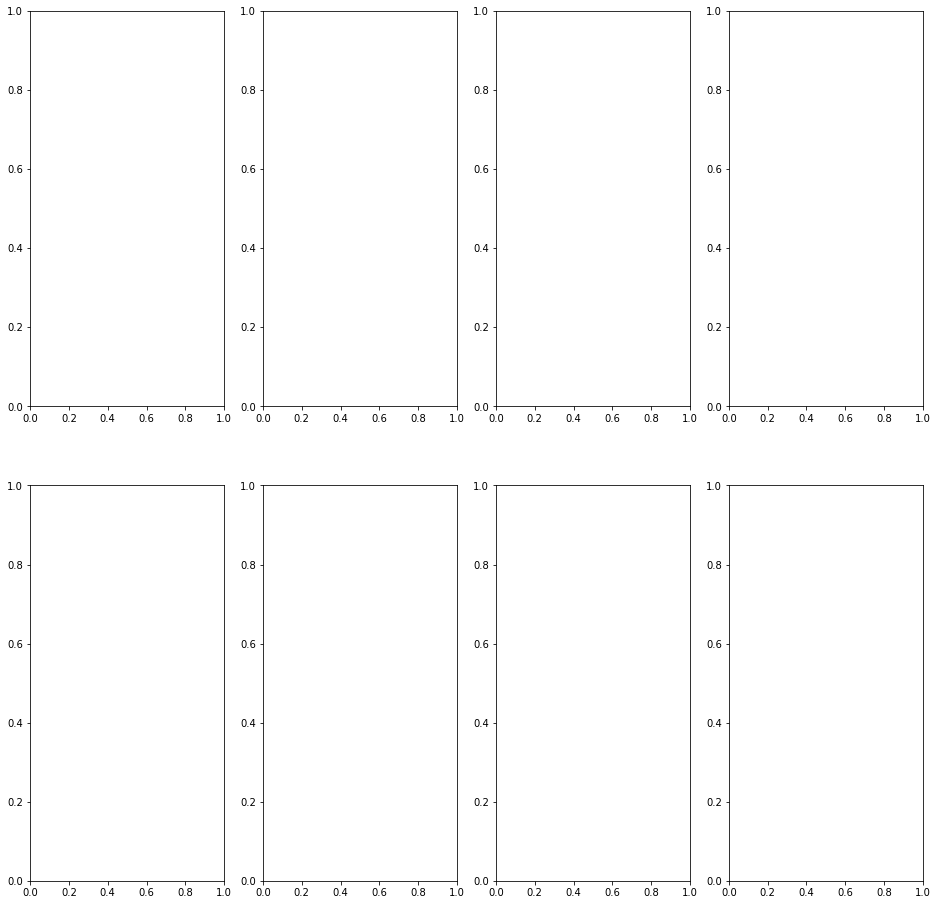

In [ ]:
#This snippet of code is used just to plot the images as an example, in order to inspect them    
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,4*num_col))
for i in range(num_row*num_col):
  if i < 8:
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### DATA AUGMENTATION

In [ ]:
#WRITE THE PATHS WHERE THE IMAGES ARE GOING TO BE TAKEN FROM
training_dir = "/content/data_splitted_final/train"
validation_dir = "/content/data_splitted_final/val"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(height_shift_range=0.45,
                                        width_shift_range=0.45,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        preprocessing_function = preprocess_input,) 

valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,)


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                           target_size= (96,96),
                                                           color_mode='rgb',
                                                           classes=None, # can be set to labels
                                                           class_mode='categorical',
                                                           batch_size=16,
                                                           shuffle=True,
                                                           seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size= (96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=16,
                                               shuffle=False,
                                               seed=seed)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


# LEARN

### MODEL METADATA

In [ ]:
input_shape = (144, 144, 3)
epochs = 100

### CNN MODEL: TRANSFER LEARNING PART

In [ ]:
#DOWNLOAD THE PRETRAINED VGG19. SET ALL LAYERS TO NON TRAINABLE
vgg_conv = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(144, 144, 3))
for layer in vgg_conv.layers:
    layer.trainable = False
vgg_conv.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 144, 144, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 144, 144, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 144, 144, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 72, 72, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 72, 72, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 72, 72, 128)       147584    
                                                              

In [ ]:
#THE ACTUAL MODEL: INPUT + RESIZING TO FIT THE IMAGE IN THE PRETRAINED MODEL + VGG19 + GLOBALAVERAGEPOOLING2D + DENSE LAYERS
inputs = tfkl.Input(shape=(96,96,3))
x = tfkl.Resizing(144,144, interpolation="nearest", crop_to_aspect_ratio = False)(inputs)
x = vgg_conv(x)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.1, seed=seed)(x)
x = tfkl.Dense(1024, activation = 'relu')(x)
x = tfkl.Dense(512, activation = 'relu')(x)
x = tfkl.LeakyReLU(alpha=0.1)(x)
output_layer = tfkl.Dense(
        units = 8, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)

model = tfk.Model(inputs = inputs, outputs = output_layer, name = 'model')

labels, batchSize, totalEpochs, learningRate, dropout, key = 8, 64, 20, 0.01, 0.5, "SGD"
weightDecay = learningRate/totalEpochs

optim = tfk.optimizers.Adam()

model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

model.summary()

NameError: ignored

In [ ]:
# Train the model: 100 epochs 
checkpoint = tfk.callbacks.ModelCheckpoint("/content/model/", monitor='val_acc', verbose=1, save_best_only=True, mode='auto', save_weights_only = True)
reduceLROnPlat = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = tfk.callbacks.EarlyStopping(monitor="'val_acc'", mode="auto", patience=30) 

callbacks_list = [checkpoint, early, reduceLROnPlat]

history = model.fit(
    x = aug_train_gen,
    epochs = 100,
    validation_data = valid_gen,
    callbacks = callbacks_list 
).history

Epoch 1/100
177/177 [==============================] - 13s 71ms/step - loss: 1.7343 - accuracy: 0.4517 - val_loss: 1.2693 - val_accuracy: 0.5316 - lr: 0.0010
Epoch 2/100
177/177 [==============================] - 12s 69ms/step - loss: 1.2836 - accuracy: 0.5175 - val_loss: 1.2014 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 3/100
177/177 [==============================] - 13s 73ms/step - loss: 1.2219 - accuracy: 0.5574 - val_loss: 1.1824 - val_accuracy: 0.5792 - lr: 0.0010
Epoch 4/100
177/177 [==============================] - 12s 68ms/step - loss: 1.1771 - accuracy: 0.5596 - val_loss: 1.2356 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 5/100
177/177 [==============================] - 12s 69ms/step - loss: 1.1391 - accuracy: 0.5737 - val_loss: 1.1702 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 6/100
177/177 [==============================] - 12s 69ms/step - loss: 1.1252 - accuracy: 0.5790 - val_loss: 1.1121 - val_accuracy: 0.5792 - lr: 0.0010
Epoch 7/100
177/177 [==============================]

### Plot the training

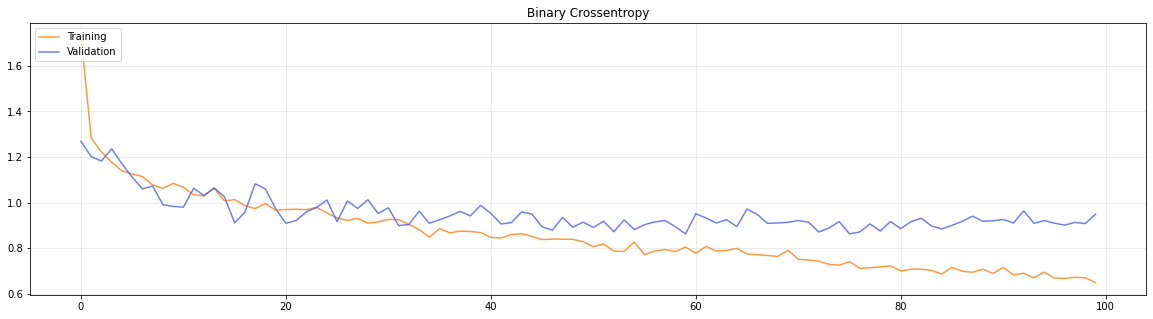

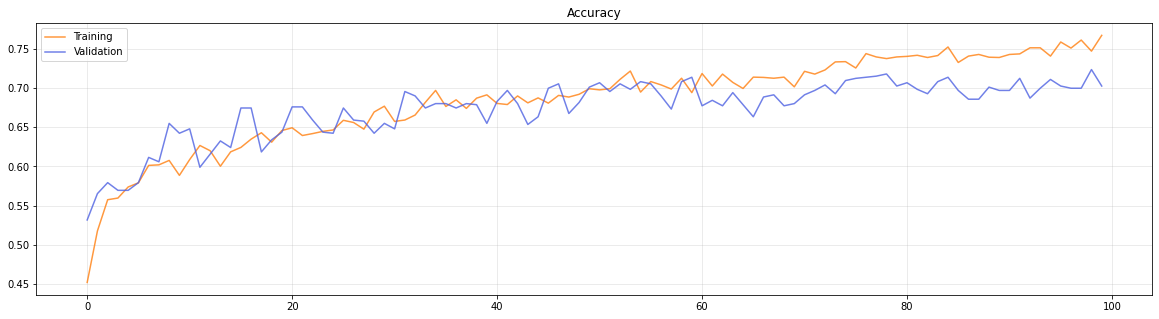

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Show Statistics

### Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save('/content/drive/MyDrive/A2NDL/vgg19')

In [ ]:
%cd /content/drive/MyDrive/A2NDL

### Fine Tuning

In [ ]:
#LOAD THE MODEL
ft_model = tfk.models.load_model('/content/model/')

In [ ]:
ft_model.summary()

In [ ]:
# Set all exception layers to True
ft_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

ft_model.summary()

In [ ]:
#UNFREEZE SOME LAYERS
for i, layer in enumerate(ft_model.get_layer('vgg19').layers[:14]):
  layer.trainable=False
#SEE THE LAYERS THAT ARE FREEZE AND THOSE WHO ARE NOT
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_5 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing_2 (Resizing)       (None, 144, 144, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 

In [ ]:
# Compile the model: THIS TIME THE LEARNING RATE IS SMALLER TO DO THE FINE TUNING
sgd=tfk.optimizers.SGD(lr=0.00001,momentum=.9,nesterov=False)
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.0001), metrics='accuracy')


In [ ]:
history = ft_model.fit(
    x = aug_train_gen,
    epochs = 150,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)] #,    class_weight= class_weights
).history

Epoch 1/150
177/177 [==============================] - 16s 87ms/step - loss: 1.5026 - accuracy: 0.4542 - val_loss: 1.2152 - val_accuracy: 0.5217
Epoch 2/150
177/177 [==============================] - 15s 86ms/step - loss: 1.2264 - accuracy: 0.5461 - val_loss: 1.1166 - val_accuracy: 0.6003
Epoch 3/150
177/177 [==============================] - 15s 85ms/step - loss: 1.0823 - accuracy: 0.6105 - val_loss: 0.9399 - val_accuracy: 0.6592
Epoch 4/150
177/177 [==============================] - 15s 84ms/step - loss: 1.0084 - accuracy: 0.6345 - val_loss: 0.8147 - val_accuracy: 0.7139
Epoch 5/150
177/177 [==============================] - 15s 84ms/step - loss: 0.9214 - accuracy: 0.6787 - val_loss: 0.8626 - val_accuracy: 0.6564
Epoch 6/150
177/177 [==============================] - 15s 85ms/step - loss: 0.8664 - accuracy: 0.6974 - val_loss: 0.9482 - val_accuracy: 0.6816
Epoch 7/150
177/177 [==============================] - 15s 85ms/step - loss: 0.8278 - accuracy: 0.7109 - val_loss: 0.8665 - val_ac

In [ ]:
ft_model.save('/content/drive/MyDrive/A2NDL/vgg19')

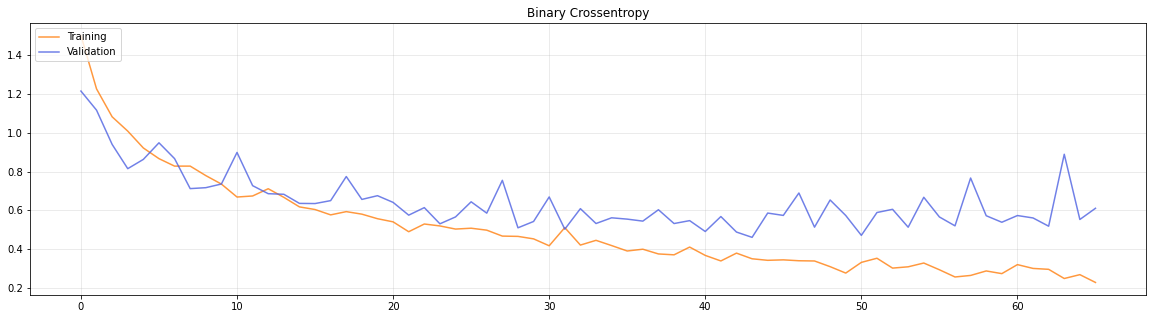

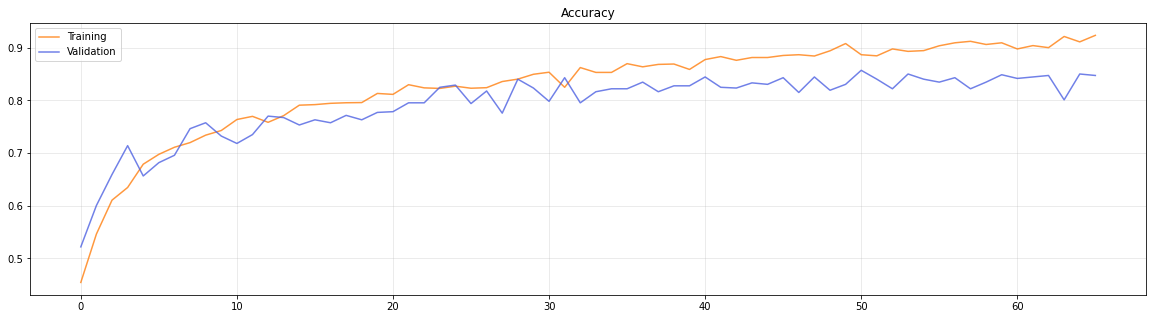

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()